<a href="https://colab.research.google.com/github/sjosephnyc1987/public_ipython_Notebooks/blob/main/SJoseph_MasteWorks_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment - The team is interested in understanding the following:

1.	Using Price divided by Low Estimate (called the PLE ratio) as a metric of beating expectations, what is the relationship between that and the dollar value of the low estimate?
2.	Is the PLE ratio correlated with the order that a lot is auctioned? Do earlier lots perform better than those that come later?


In [ ]:
!pip install requests

In [ ]:
#imports
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#for non-linear regression
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#reading in the date as a CSV file into Pandas dataFrame
url = 'https://raw.githubusercontent.com/sjosephnyc1987/datasets/main/StephenJoseph-case_study_vp_analytics.csv'
df = read_csv(url)


In [ ]:
#importing a custom non-linear regression library i wrote
#see more here https://github.com/sjosephnyc1987/funcspinner

import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
cust_url = 'https://raw.githubusercontent.com/sjosephnyc1987/funcspinner/main/funcspinner.py'
r = requests.get(cust_url)

# make sure your filename is the same as how you want to import 
with open('funcspinner.py', 'w') as f:
    f.write(r.text)

# now we can import
import funcspinner 

In [ ]:
#CLEAN-UP
#lot_numbers are not labelled consistently and so we're cleaning that up

old_list=[]
new_list=[]

for i in range(101,159):
    old_list.append(i)
    new_list.append(i-100)

df['lot_number']= df['lot_number'].replace(old_list,new_list)


In [ ]:
#let's see if our clean-up worked.
df['lot_number'].describe()

count    230.000000
mean      25.226087
std       15.368863
min        1.000000
25%       12.000000
50%       24.000000
75%       37.000000
max       58.000000
Name: lot_number, dtype: float64

In [ ]:
#Dropping NAs - there are some price fields that are empty and so we're going to drop them. But let's also make sure we're not dropping too much of that.
print("length of df = ", len(df))
print("length of dropped na_df = ", len(df.dropna()))
df = df.dropna()
print("new length of df = ", len(df))


length of df =  230
length of dropped na_df =  215
new length of df =  215


In [ ]:
#Next we Creatre the PLE column
df['PLE'] = df['price_usd']/df['low_estimate_usd']
df.describe()

,lot_number,price_usd,low_estimate_usd,high_estimate_usd,PLE
count,215.000000,2.150000e+02,2.150000e+02,2.150000e+02,215.000000
mean,24.730233,2.210768e+06,1.508808e+06,2.148423e+06,2.072129
std,15.520314,6.698696e+06,4.878640e+06,6.658543e+06,2.430217
min,1.000000,2.256500e+04,1.160500e+04,1.547300e+04,0.845000
25%,11.500000,2.970450e+05,1.295950e+05,2.000000e+05,1.166580
50%,23.000000,6.523820e+05,4.000000e+05,6.220580e+05,1.476944
75%,37.000000,1.732067e+06,1.000000e+06,1.500000e+06,2.111752
max,58.000000,8.455000e+07,6.000000e+07,8.000000e+07,30.333333


In [ ]:
#Let's start off doing a simple regression from ScikitLearn

X=np.array(df['PLE']).reshape((-1,1))
y=np.array(df['low_estimate_usd'])

model = LinearRegression().fit(X, y)
r_sq = model.score(X, y)

#Sci-kit learn does not give us Standard Error and so we have to calulate that ourselves.
#First we calculate the residuals in order to get the standard error
prediction = model.predict(X)
residuals = (y - prediction)

#then we calculate RMSE
squaresumofresiduals = np.sum(residuals**2) 
std_error = np.sqrt(squaresumofresiduals/len(prediction))
print("standard error manually calculated from scikit_learn = ", str(std_error))

#regression coeffiecents
print('coefficient of determination R-sq:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


standard error manually calculated from scikit_learn =  4852606.3201466985
coefficient of determination R-sq: 0.006020694572487328
intercept: 1831578.2807378164
slope: [-155767.52066177]


-------come back to this ---------------

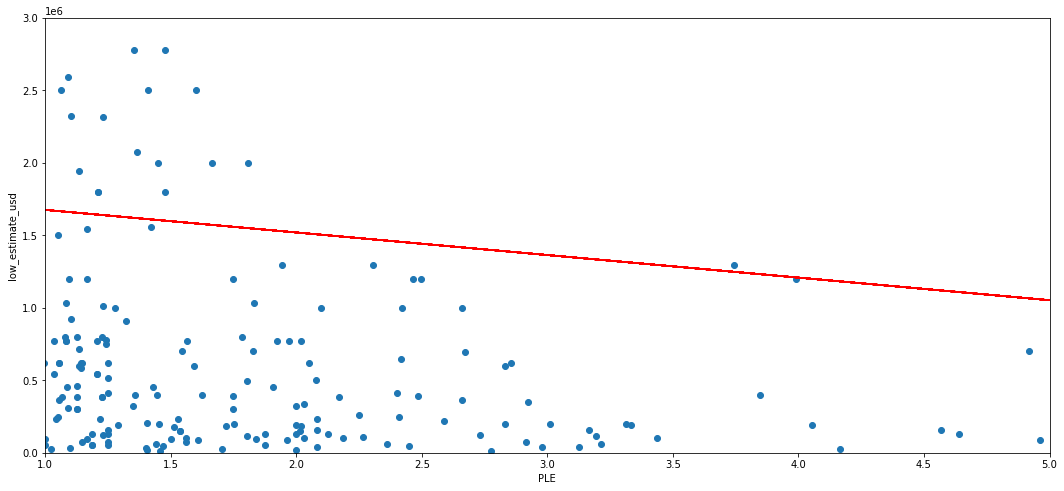

In [23]:
#plotting'
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(X, y)
ax.set_xlim(1, 5)
ax.set_ylim(0, 3000000);
ax.set_xlabel("PLE")
ax.set_ylabel("low_estimate_usd")

plt.plot(X, model.predict(X),color='r')

#plt.scatter(y, X, color='r')
#plt.plot(y, X, color='r')

In [25]:
#Let's verify this using statmodels
print("\n-------------using statsmodels--------------")

import statsmodels.api as sm

#getting some nwew varibles 
xx = df['PLE']
yy = df['low_estimate_usd']

h = np.array(xx)
w = np.array(yy)

#to make statsmodels work, you have to add a constant to X
h = sm.add_constant(h)

model2 = sm.OLS(w, h) #note that the x and y are inverted here.
results2 = model2.fit()
print(results2.summary())

std_error_model = np.sqrt(results2.scale)
print("standard error from stats_models = ", std_error_model)



-------------using statsmodels--------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.290
Date:                Sat, 24 Sep 2022   Prob (F-statistic):              0.257
Time:                        06:14:13   Log-Likelihood:                -3615.0
No. Observations:                 215   AIC:                             7234.
Df Residuals:                     213   BIC:                             7241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

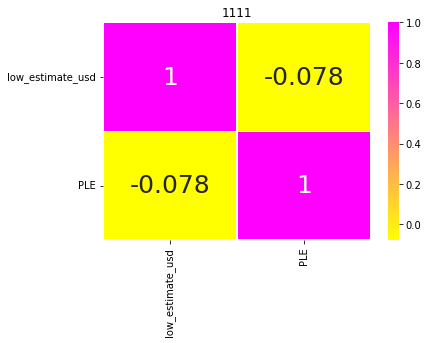

In [ ]:
#correlation
corr_matrix_inputs = df[['low_estimate_usd','PLE']]
corr_matrix = corr_matrix_inputs.corr()

sns.heatmap(data=corr_matrix, annot=True, cmap="spring_r", linewidths=0.3, annot_kws={"size": 25}).set(title='1111')
#Plot aesthetics
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

Text(0.5, 1.0, 'PLE vs lot_number')

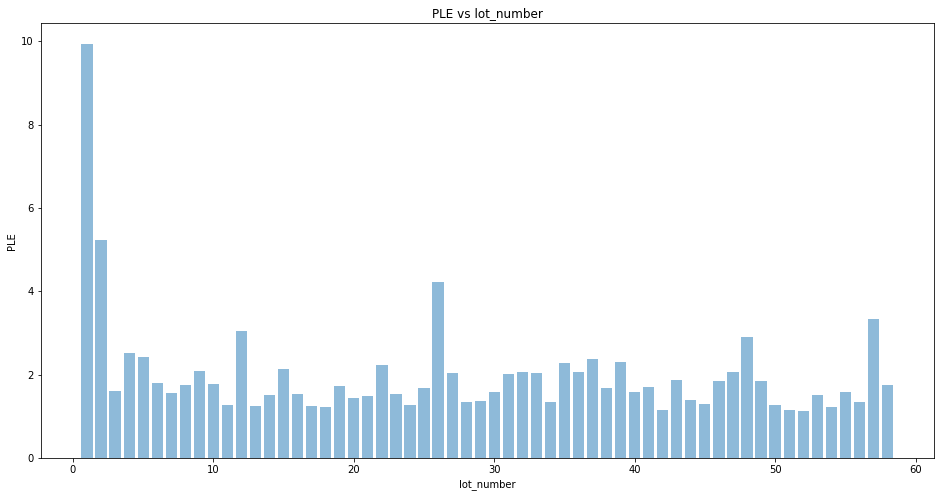

In [ ]:
#Does lot_number mean anythign
dfg = df.groupby(['lot_number']).mean()['PLE']
#dfg.plot(kind='bar')

fig2, ax2 = plt.subplots(figsize=(16,8))
#dfg.bar(
plt.bar(dfg.index, dfg, align='center', alpha=0.5)
plt.xlabel('lot_number')
plt.ylabel('PLE')
plt.title('PLE vs lot_number')



#Non-Linear Regression

In [28]:

#--------cyclign through a bunch of functios for non-linear regression------

list_of_functions = ["simpleLinear",	"quadratic",	"cubic",	"saturationGrowthRate",	"simpleExponential",	
                     "simplePower",		"michaelisMenten",	"reciprocal",	
                     "bleasdaleNelder",	"farazdagiHarris",	"holliday",	"exponential",	"threeParameterLogistic",	
                     "gompertz",	"weibull",		
                     "exponential1",	"exponential2",	"normal",	"lognormal",	"exponentialVariation",	"michaelisMenten2",	
                     "michaelisMenten3",	"linearLinear",	"linearQuadratic",		"quadraticQuadratic",	"linear3",	
                     "gompertz2",	"hill2",	"sum3Exponentials",	"gaussian",]

#removed "polyRatio22", "polyRatio33", "polyRatio44", "richards","logarithmic","power","sumexponentials",	
#"quadraticLinea",

results_matrix = pd.DataFrame(columns=['function_name', 'standard_error'])


for functionname in list_of_functions:
        
    #get the function from the funcspinner class.
    objective_function = funcspinner.function_return(functionname)
    
    #if we want to see what's in the function returned
    import inspect
    #print(inspect.getsource(objective_function))
    
    # do the actual curve fit
    fit_paramsL, covariances = curve_fit(objective_function, xx, yy, maxfev=500000)
    
    
    #print ("Fitting curve using the", functionname, "function")
    #print ("-----------------")
    #print('Parameter values: ')
    
    #for printing out the results.
    coeffs = ["a","b","c","d","e","f","g","h","i","j","k"]
    
    i=0
    for coeff in fit_paramsL:
        #print(coeffs[i], "=" , coeff)
        i = i+1
    
    
    x_monotonic = np.arange(min(xx),max(xx),1)
    y_fit = objective_function(x_monotonic,*fit_paramsL)
    
    
    #to calulate the standard error
    #---------------------------------
    #x_expected = np.linspace(min(x),max(x),len(x))
    
    #you can get standard error of individual variables using np.sqrt(np.diag(covariances)) 
    
    y_expected = objective_function(np.array(xx),*fit_paramsL)
    
    residuals = yy - y_expected
    squaresumofresiduals = np.sum(residuals**2)
    std_error = np.sqrt(squaresumofresiduals/len(y_expected))
    print("standard error from the ",functionname , "model = " ,str(round(std_error,2)))
    
    results_matrix = results_matrix.append({'function_name':functionname , 'standard_error': str(round(std_error,2))}, ignore_index=True)
 


standard error from the  simpleLinear model =  4852606.32
standard error from the  quadratic model =  4833368.98
standard error from the  cubic model =  4826399.4
standard error from the  saturationGrowthRate model =  4844968.63
standard error from the  simpleExponential model =  4825649.11
standard error from the  simplePower model =  4831337.19
standard error from the  michaelisMenten model =  4844968.63
standard error from the  reciprocal model =  5095495.84
standard error from the  bleasdaleNelder model =  5095774.76
standard error from the  farazdagiHarris model =  5095317.15
standard error from the  holliday model =  5095499.98


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


standard error from the  exponential model =  4867291.44
standard error from the  threeParameterLogistic model =  4867280.65
standard error from the  gompertz model =  4867280.65
standard error from the  weibull model =  5095645.33


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


standard error from the  exponential1 model =  4800960.42
standard error from the  exponential2 model =  4824983.49
standard error from the  normal model =  4852715.1
standard error from the  lognormal model =  4263934.38
standard error from the  exponentialVariation model =  4825649.11
standard error from the  michaelisMenten2 model =  4844968.63
standard error from the  michaelisMenten3 model =  4844968.63
standard error from the  linearLinear model =  4852606.32
standard error from the  linearQuadratic model =  5013203.88
standard error from the  quadraticQuadratic model =  4833368.98
standard error from the  linear3 model =  4852606.32
standard error from the  gompertz2 model =  4867280.65
standard error from the  hill2 model =  5095774.71


/content/funcspinner.py:129: RuntimeWarning: invalid value encountered in double_scalars
  def hill2(x,a,b,c): return (a*(x**c))/((b**c)+(x**c))


standard error from the  sum3Exponentials model =  4825649.11
standard error from the  gaussian model =  4800647.54


In [29]:
print(results_matrix.sort_values(by=['standard_error']))

             function_name standard_error
18               lognormal     4263934.38
29                gaussian     4800647.54
15            exponential1     4800960.42
16            exponential2     4824983.49
4        simpleExponential     4825649.11
19    exponentialVariation     4825649.11
28        sum3Exponentials     4825649.11
2                    cubic      4826399.4
5              simplePower     4831337.19
1                quadratic     4833368.98
24      quadraticQuadratic     4833368.98
6          michaelisMenten     4844968.63
21        michaelisMenten3     4844968.63
20        michaelisMenten2     4844968.63
3     saturationGrowthRate     4844968.63
25                 linear3     4852606.32
22            linearLinear     4852606.32
0             simpleLinear     4852606.32
17                  normal      4852715.1
13                gompertz     4867280.65
12  threeParameterLogistic     4867280.65
26               gompertz2     4867280.65
11             exponential     486